Áp dụng BigData phân tích các yếu tố ảnh hưởng đến giá nhà và xây dựng mô hình dự đoán giá nhà.

**1. Import thư viện**

In [6]:
!pip install pyspark

In [7]:
# import libraries
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql.functions import * # importig SQL functions
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

import os

from pyspark.sql import SparkSession, SQLContext

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator



In [8]:
spark = SparkSession.builder.appName('Housing_Price_Prediction').getOrCreate()
spark


**2. Data Processing**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import data


In [10]:
# Read the datasets
df_housing = spark.read.csv("/content/drive/MyDrive/NĂM 4/Big Data/Housingprice/housing.csv", inferSchema=True, header=True)

In [11]:
# print the schema of the dataset
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [12]:
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [13]:
# count the number of rows and columns in the dataset
print((df_housing.count(), len(df_housing.columns)))

(20640, 10)


In [14]:
# Check null values
df_housing.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_housing.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [15]:
# Drop the null values
df_housing = df_housing.dropna()

In [16]:
# Check null values again
df_housing.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_housing.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [17]:
#Check duplicates
df_housing.count() - df_housing.dropDuplicates().count()

0

In [18]:
# Describe the dataset
df_housing.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+
|summary|          longitude|          latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|        households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+
|  count|              20433|             20433|             20433|             20433|             20433|             20433|             20433|             20433|             20433|          20433|
|   mean|-119.57068859198068| 35.63322125972706|28.633093525179856|2636.5042333480155| 537.8705525375618|1424.9469485635982|499.43346547251997|3.8711616013312273|206864.41315519012|           NULL|
| stddev| 

In [19]:
#column overview
pd.DataFrame(df_housing.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [20]:
df_housing = df_housing.withColumnRenamed('median_house_value','price')

In [21]:
type(df_housing['price'])

pyspark.sql.column.Column

<Axes: xlabel='ocean_proximity', ylabel='price'>

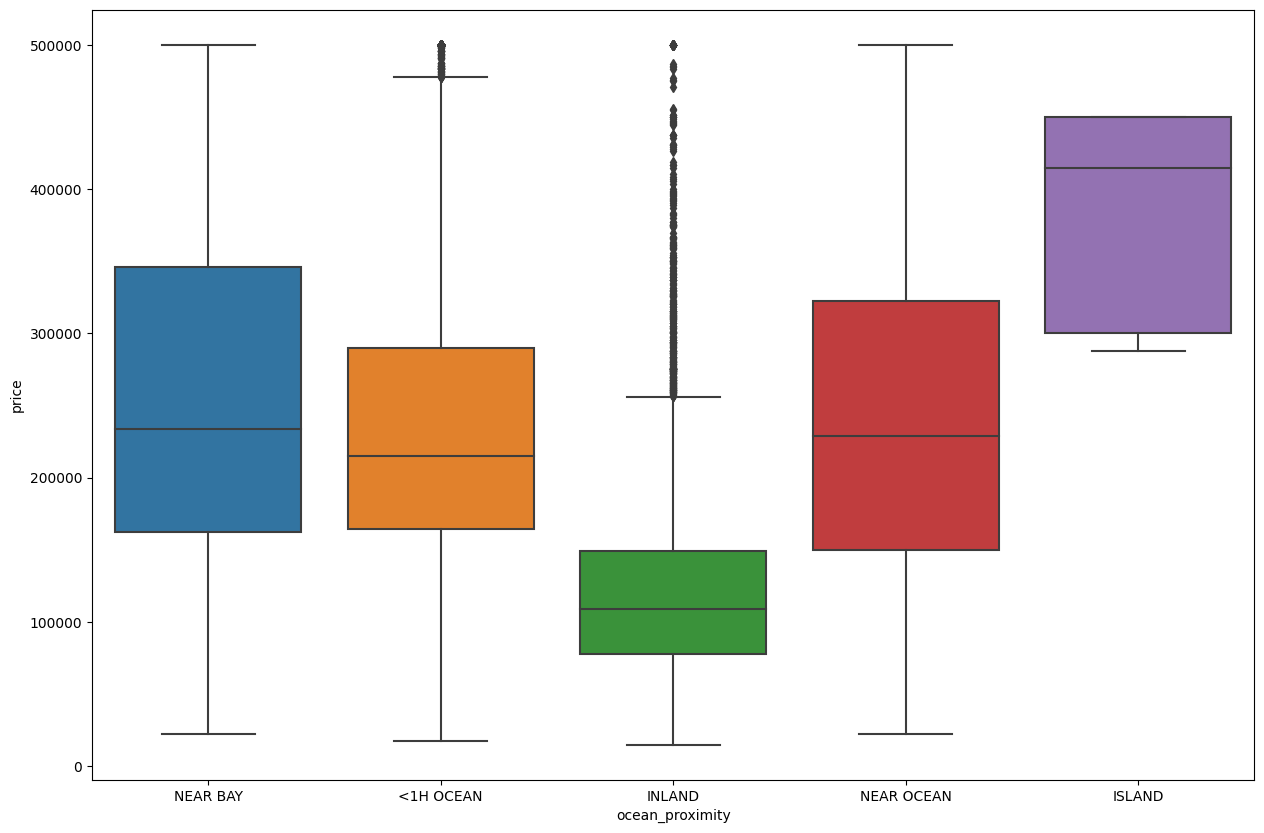

In [22]:
#visualize outliers
plt.figure(figsize=(15,10))
sns.boxplot(x='ocean_proximity', y='price', data=df_housing.toPandas())

**EDA**

<Figure size 1000x400 with 0 Axes>

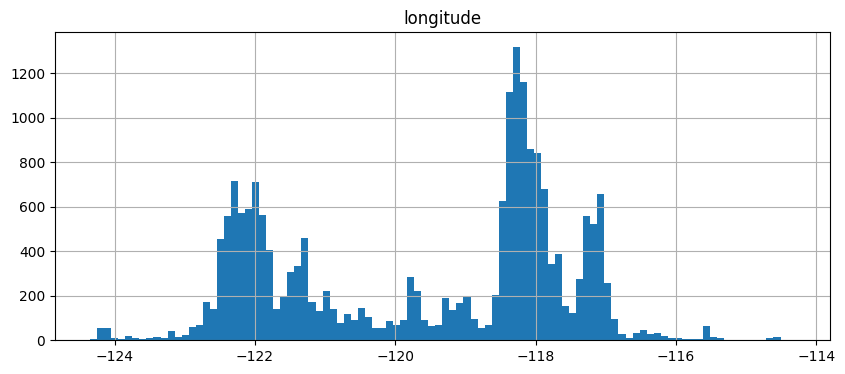

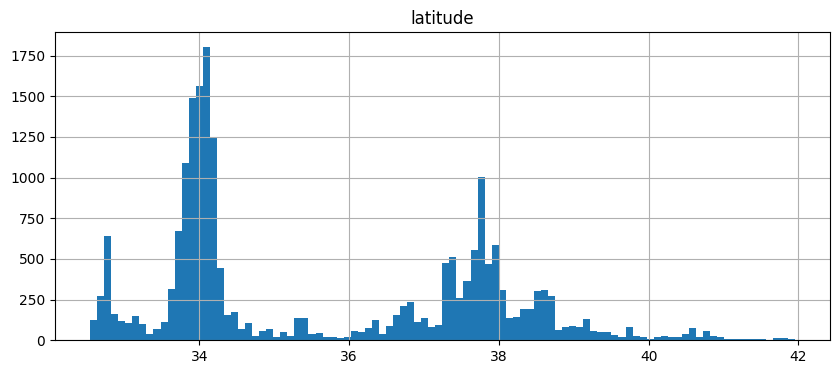

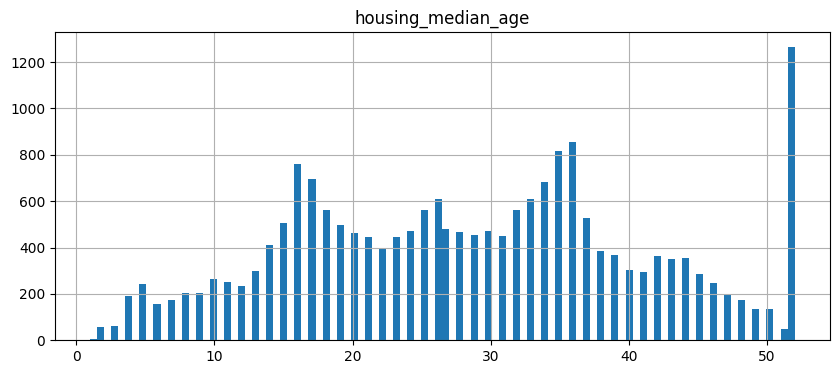

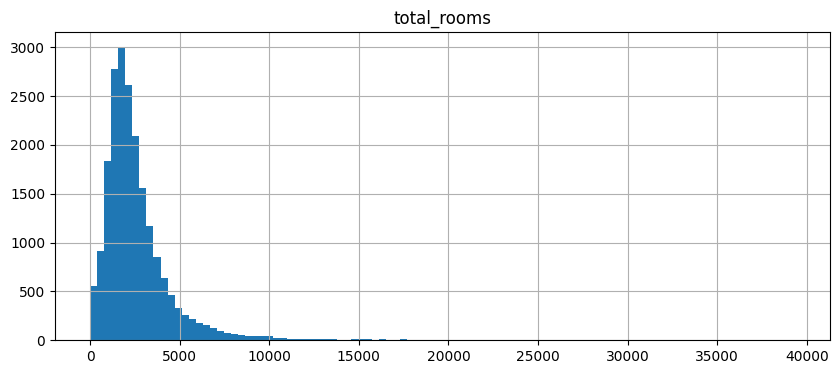

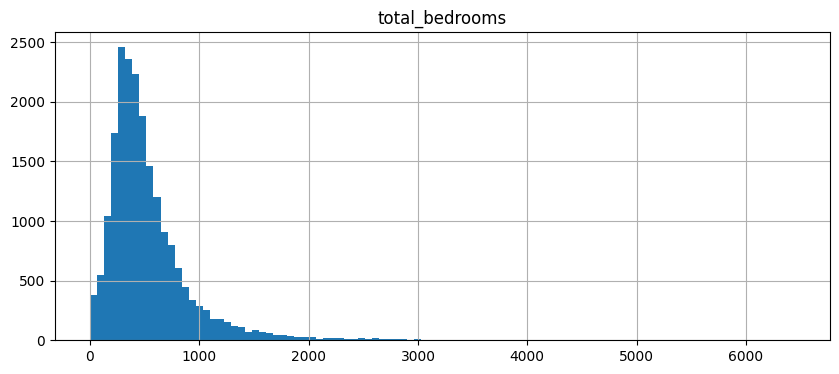

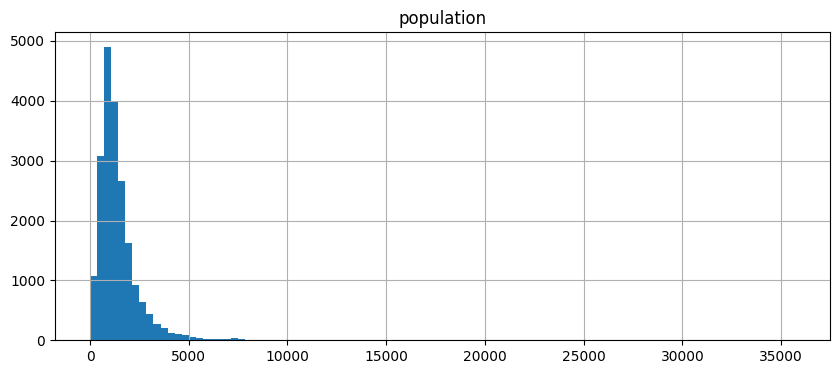

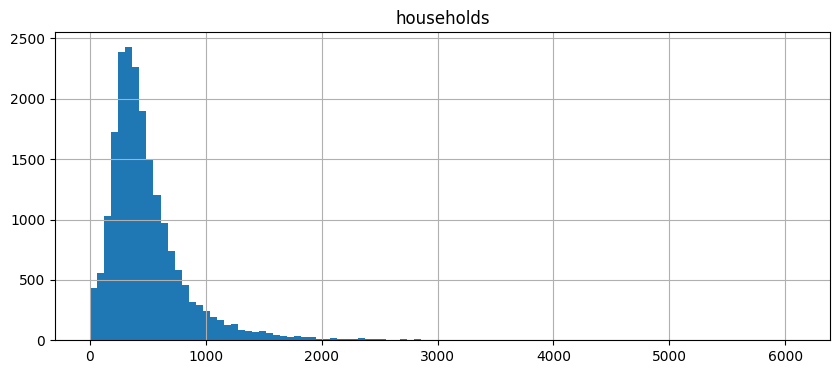

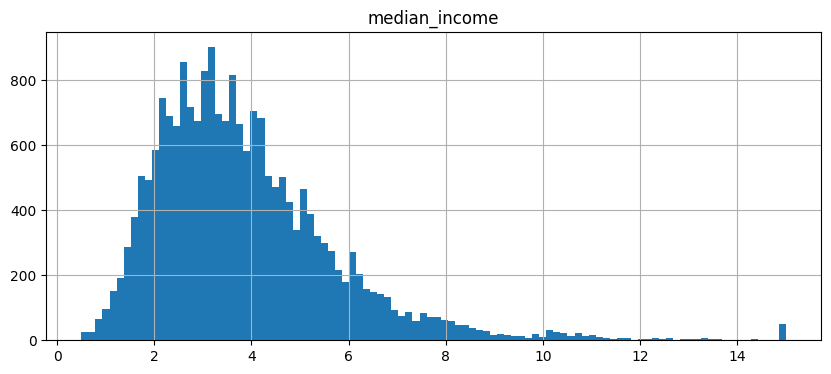

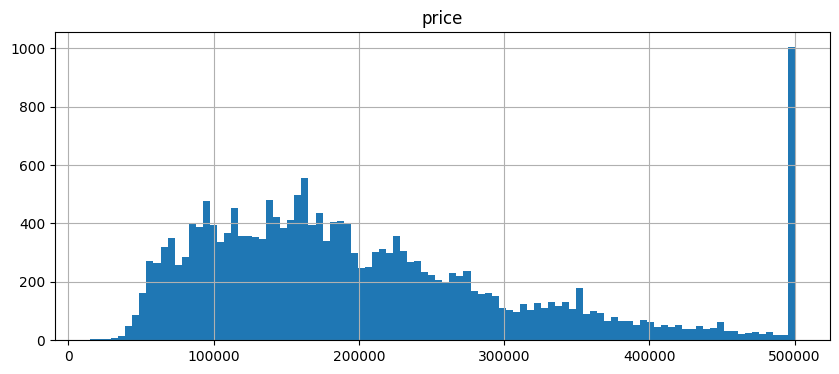

In [23]:
# Lấy tên các cột chứa dữ liệu số
numeric_columns = [col[0] for col in df_housing.dtypes if col[1] in ['int', 'double']]

# Vẽ histogram cho từng cột số

plt.figure(figsize=(10, 4))
for column in numeric_columns:
    df_housing.select(column).toPandas().hist(bins=100, figsize=(10, 4))
    plt.title(column)
plt.show()

Bằng cách nhìn vào sự phân bố của từng dữ liệu, chúng ta có thể quan sát được một số điều.

trung bình_thu nhập : Có vẻ như nó được giới hạn ở mức 15
housing_median_age và middle_house_value : Những giá trị này cũng bị giới hạn .
Điều quan trọng là phải tìm hiểu hành vi của từng thuộc tính. Xem xét trường hợp trên nếu chúng ta đào tạo một mô hình trực tiếp ở trên thì mô hình của chúng ta có thể biết rằng thu nhập sẽ không bao giờ vượt quá 15, điều này không đúng. Điều tương tự cũng có thể nói cho điểm số 2

Chúng ta sẽ phải giải quyết những vấn đề này ở phần chia tỷ lệ tính năng.

Phân tích biến Price

<ipython-input-24-a2655b462d64>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('price').toPandas(), color="skyblue")


+------------------+------------------+
|   skewness(price)|   kurtosis(price)|
+------------------+------------------+
|0.9782180725222175|0.3276635760679656|
+------------------+------------------+



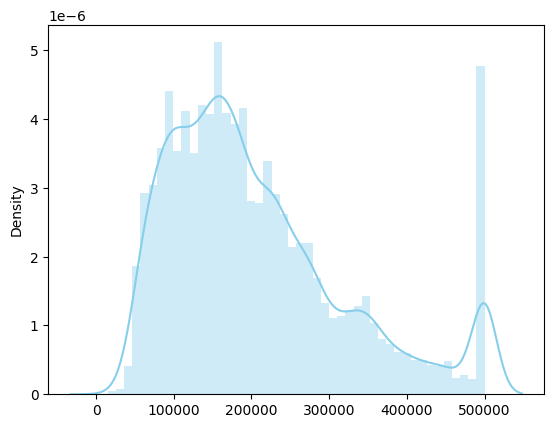

In [24]:
#Checking if the prices are normally distributed
sns.distplot(df_housing.select('price').toPandas(), color="skyblue")
df_housing.select(F.skewness('price'), F.kurtosis('price')).show()

In [25]:
print("No of houses: %i" % df_housing.select('price').count())
print("No of houses greater than $500000 are: %i" % df_housing.filter(df_housing["price"] > 500000).count())

No of houses: 20433
No of houses greater than $500000 are: 958


In [26]:
#Counting per capita that are less than $100
price_count = df_housing.filter('price >  500000').count()/df_housing.select('price').count()*100
print("Percentage of price > 500000 a: %2f" % price_count)

Percentage of price > 500000 a: 4.688494


<Axes: ylabel='Count'>

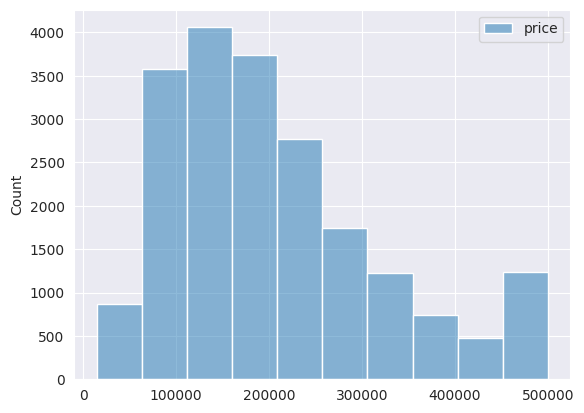

In [27]:
#Distribution of prices
sns.set_style("darkgrid")
sns.histplot(df_housing.select('price').toPandas(), bins = 10)

Giá nhà phổ biến nằm trong phân khúc từ 100,000 USD - 200,000 USD
Phân khúc nhà có giá trị cao nhất lên đến 500.000 USD, chiếm 958 trong tổng số 20433 căn nhà, tỷ lệ là 4.68%.

Price theo Total rooms:

<Axes: xlabel='total_rooms', ylabel='avg(price)'>

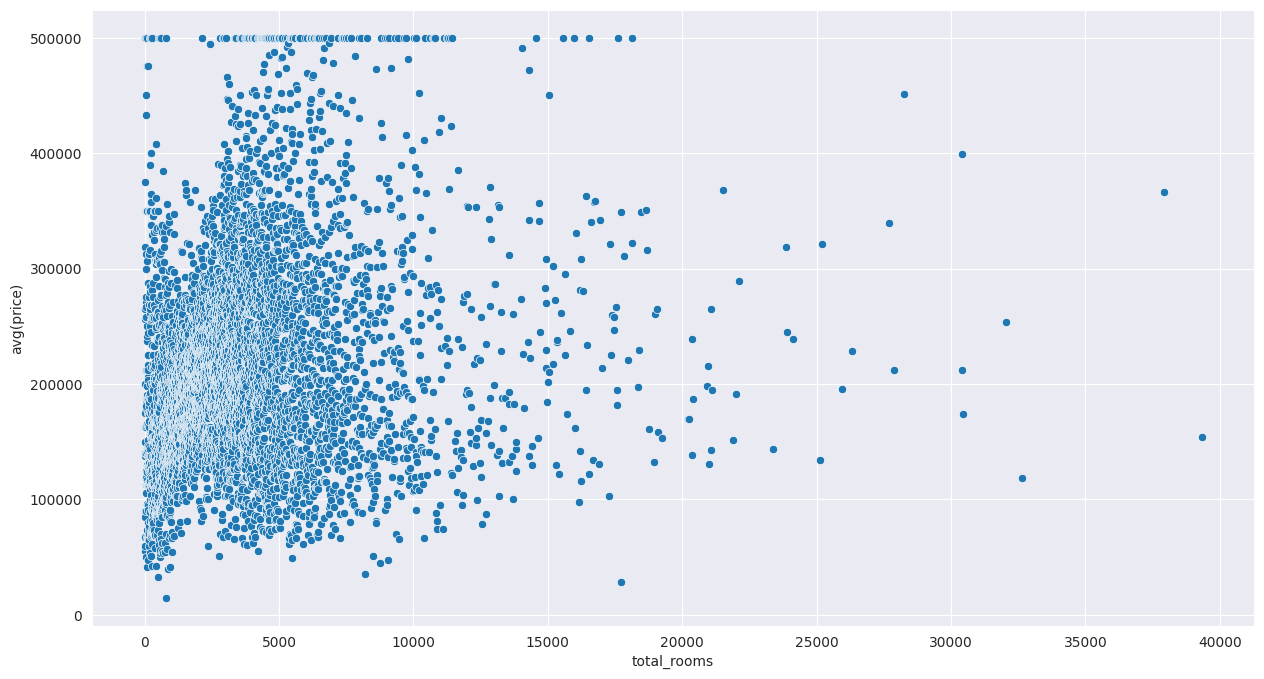

In [28]:
#Average price of house
import matplotlib.pyplot as plt
df1 = df_housing.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(price)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(price)'] )

Số phòng trong khoảng từ 5.000 - 10.000 là chiếm số lượng nhiều nhất với các phân khúc giá trải dài trên giá trị của cột price. Có thể thấy tập trung nhiều nhất trong khoảng 100.000 - 300.000

**Thu nhập bình quân đầu người ảnh hưởng ntn đến giá bất động sản?**

In [29]:
#Adding a column of per-capita income to the dataframe (Thu nhập bình quân đầu người)

df_housing = df_housing.withColumn('per_capita_income', df_housing['median_income']*10000/df_housing['population'])

[(0.0, 500.0)]

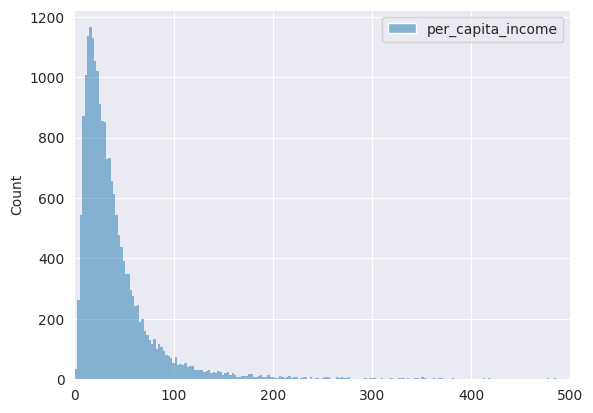

In [30]:
#per_capita_income distribution
g = sns.histplot(df_housing.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))

<Axes: xlabel='per_capita_income', ylabel='price'>

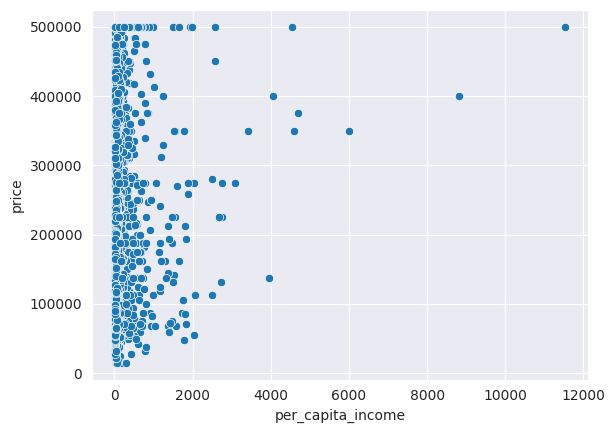

In [31]:
#Per-capita-income and prices of the home
df_p = df_housing.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['price'])

#A lot of data has near $100 per-capita income - data is skewed towards zero.

In [32]:
#Counting per capita that are less than $100
count_blocks = df_housing.filter('per_capita_income <  100').count()/df_housing.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 92.595312


Phần lớn người dân có thu nhập dưới 100 USD có tỷ lệ là 92.5%, gia trị bất động sản cũng phân bố tương ứng như thu nhập.

In [33]:
#Checking unique values in ocean_proximity
df_housing.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



In [34]:
# Đếm số lượng giá trị duy nhất trong cột 'Ocean_Proximity'
value_counts = df_housing.groupBy("Ocean_Proximity").agg(count("*").alias("count")).toPandas()

# Chuyển đổi thành từ điển
value_counts_dict = dict(zip(value_counts["Ocean_Proximity"], value_counts["count"]))

print(value_counts_dict)

{'ISLAND': 5, 'NEAR OCEAN': 2628, 'NEAR BAY': 2270, '<1H OCEAN': 9034, 'INLAND': 6496}


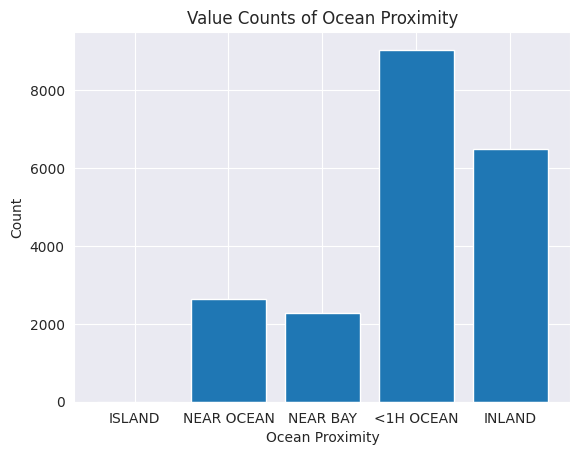

In [35]:
# Tạo biểu đồ
fig, ax = plt.subplots()
ax.bar(value_counts_dict.keys(), value_counts_dict.values())
ax.set_xlabel('Ocean Proximity')
ax.set_ylabel('Count')
ax.set_title('Value Counts of Ocean Proximity')

# Hiển thị biểu đồ
plt.show()

<Axes: xlabel='ocean_proximity', ylabel='avg(median_income)'>

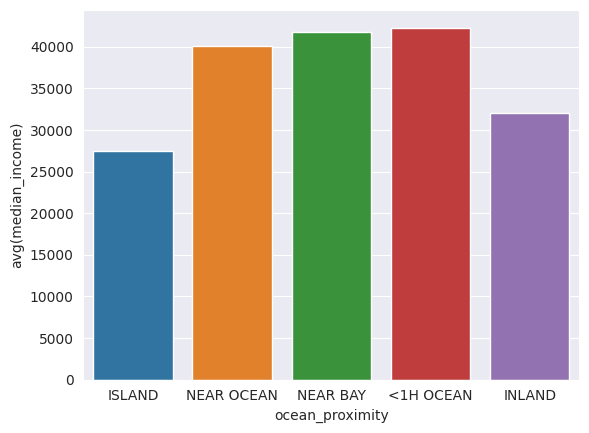

In [36]:
#Where does wealthy people live?
df_i = df_housing.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)

#Houses that are less than 1 hour to ocean where most wealthy people wants to live

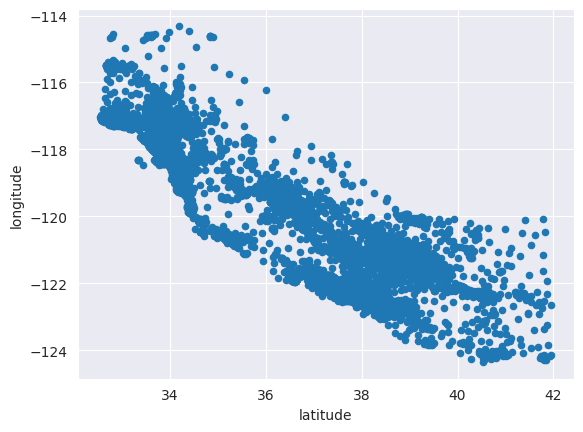

In [37]:

pandas_df = df_housing.select("latitude", "longitude").toPandas()

# Vẽ biểu đồ
pandas_df.plot(kind="scatter", x="latitude", y="longitude", grid=True)

# Hiển thị biểu đồ
plt.show()

Mức trung bình thu nhập theo biến ocean_proximity (mức độ gần biển). Theo đó <1h Ocean (cách biển 1 giừo di chuyển) có thu nhập cao nhất ( tức là những người giàu thường tập trung sống ở đây). Những nơi này có vị trí thuận lợi hơn

Từ việc khám phá ở trên, chúng tôi đã chỉ ra rằng có mối tương quan chặt chẽ giữa thu nhập trung bình và mục tiêu; cũng như mối tương quan giữa vị trí của ngôi nhà so với vịnh (cột "ocean_proximity") và mục tiêu

In [38]:
!pip install seaborn

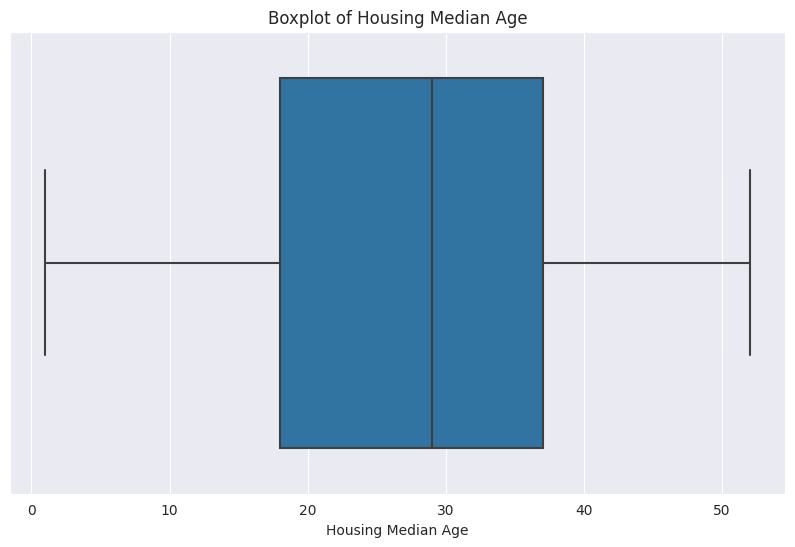

In [39]:

# Chuyển đổi DataFrame của PySpark thành Pandas DataFrame để sử dụng với Seaborn
pandas_df_housing = df_housing.toPandas()

# Vẽ boxplot sử dụng Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=pandas_df_housing['housing_median_age'])
plt.title('Boxplot of Housing Median Age')
plt.xlabel('Housing Median Age')
plt.show()

In [40]:
#Label-encoding for the "ocean_proximity" column
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
df_housing = indexer.fit(df_housing).transform(df_housing)
df_housing = df_housing.drop('ocean_proximity')
df_housing.select('ocean_proximity_index').show(3)

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows



In [41]:
#Removing na values to ensure correlation method works properly
mean = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
df_housing = df_housing.na.fill({'total_bedrooms': mean})

In [42]:
#Checking if na values exist in 'total_bedrooms' columns
df_housing.filter(col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|price|per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+---------------------+



<Axes: >

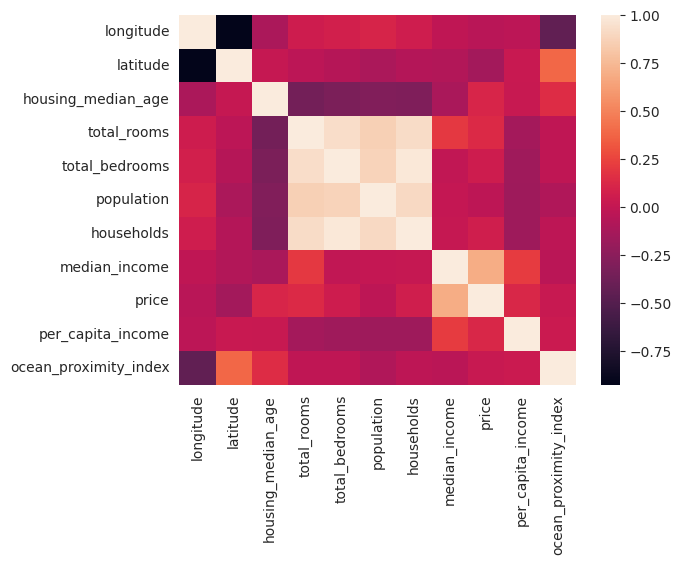

In [43]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df_housing.columns, outputCol="features")
df_vector = assembler.transform(df_housing).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df_housing.columns, index = df_housing.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr)

Biến mục tiêu price có mối tương quan rất nhẹ với tất cả ngoại trừ một đặc điểm ở đây: median_income, vì vậy người ta có thể coi đây là một đặc điểm quan trọng.
Mối tương quan -0,02 & -0,05 (dân số/kinh độ) với biến mục tiêu Average_house_value có thể đáng để giảm, nhưng cũng có thể không. Trên thực tế, giá trị thấp không hẳn là lý do để loại bỏ một tính năng. Nó có thể chỉ đơn giản ngụ ý rằng dữ liệu được lan truyền khá nhiều, đây là một dấu hiệu mạnh mẽ về tính phi tuyến.
Người ta thường khuyên nên bỏ các đặc điểm như vậy, đặc biệt đối với các mô hình ít phức tạp hơn, vì mô hình có thể sẽ không thể chọn ra một đặc điểm có tính phi tuyến như vậy chứ chưa nói đến nhiều đặc điểm.
Có thể vẽ một ma trận đã dịch chuyển, trông đẹp hơn một chút

In [44]:
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'price',
 'per_capita_income',
 'ocean_proximity_index']

In [45]:
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price| per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|258.54658385093165|                  3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0| 34.57476051645147|                  3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|146.31854838709677|                  3.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     

In [46]:
# Drop the outliers
# iqr
Q1 = df_housing.approxQuantile("price", [0.25], 0)
Q3 = df_housing.approxQuantile("price", [0.75], 0)
IQR = Q3[0] - Q1[0]
print(IQR)

145200.0


In [47]:
# min and max
MIN = Q1[0] - 1.5 * IQR
MAX = Q3[0] + 1.5 * IQR
MIN, MAX

(-98300.0, 482500.0)

In [48]:
# remove outliers
df_housing = df_housing.filter((df_housing["price"] > MIN) & (df_housing["price"] < MAX))

In [49]:
#dataset after handling outliers
df_housing.count()

19369

In [50]:
#export to csv a new file
#df_housing.toPandas().to_csv('Housing_clean.csv', index=False)

Modeling


In [51]:
df_housing.select('total_rooms').agg({'total_rooms': 'avg'}).show()

+------------------+
|  avg(total_rooms)|
+------------------+
|2620.7109298363366|
+------------------+



In [52]:
from pyspark.sql.functions import mean
df_housing.select(*[mean(c) for c in df_housing.columns]).show()

+------------------+-----------------+-----------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+----------------------+--------------------------+
|    avg(longitude)|    avg(latitude)|avg(housing_median_age)|  avg(total_rooms)|avg(total_bedrooms)|   avg(population)|  avg(households)|avg(median_income)|        avg(price)|avg(per_capita_income)|avg(ocean_proximity_index)|
+------------------+-----------------+-----------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+----------------------+--------------------------+
|-119.5639015953312|35.65578398471791|      28.34415819092364|2620.7109298363366|  539.8933347101038|1442.2850431101244|501.3039909133151|3.6654750993856484|190802.06494914554|     48.34483027089346|        0.9000464660023749|
+------------------+-----------------+-----------------------+------------------+-----------

In [53]:
train, test = df_housing.randomSplit([0.7, 0.3])
train, test

(DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, price: double, per_capita_income: double, ocean_proximity_index: double],
 DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, price: double, per_capita_income: double, ocean_proximity_index: double])

In [54]:
numerical_features_lst = train.columns
numerical_features_lst.remove('price')
numerical_features_lst.remove('per_capita_income')

numerical_features_lst

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_index']

In [55]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=numerical_features_lst,
                  outputCols=numerical_features_lst)

imputer = imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

train.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price| per_capita_income|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147| 94600.0|37.403225806451616|                  2.0|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797| 85800.0|15.251926040061633|                  2.0|
|   -124.3|   41.84|              17.0|     2677.0|         531.0|    1244.0|     456.0|       3.0313|103600.0|24.367363344051448|                  2.0|
+---------+--------+------------------+-----------+--------------+----------+-----

In [56]:
from pyspark.ml.feature import VectorAssembler
numerical_vector_assembler = VectorAssembler(inputCols=numerical_features_lst,
                                             outputCol='numerical_feature_vector')

train = numerical_vector_assembler.transform(train)
test = numerical_vector_assembler.transform(test)

train.show(2)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-------+------------------+---------------------+------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|  price| per_capita_income|ocean_proximity_index|numerical_feature_vector|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-------+------------------+---------------------+------------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147|94600.0|37.403225806451616|                  2.0|    [-124.35,40.54,52...|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797|85800.0|15.251926040061633|                  2.0|    [-124.3,41.8,19.0...|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-------+-----

In [57]:
train.select('numerical_feature_vector').take(2)

[Row(numerical_feature_vector=DenseVector([-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 270.0, 3.0147, 2.0])),
 Row(numerical_feature_vector=DenseVector([-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 478.0, 1.9797, 2.0]))]

In [58]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='numerical_feature_vector',
                        outputCol='scaled_numerical_feature_vector',
                        withStd=True, withMean=True)

scaler = scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

train.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+------------------------+-------------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price| per_capita_income|ocean_proximity_index|numerical_feature_vector|scaled_numerical_feature_vector|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+------------------------+-------------------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147| 94600.0|37.403225806451616|                  2.0|    [-124.35,40.54,52...|           [-2.3868987283142...|
|   -124.3|    41.8|              19.0|     2672.0|         552.0|    1298.0|     478.0|       1.9797| 85800.0|15.251926040061633|                  2.0|    [-12

In [59]:
train.select('scaled_numerical_feature_vector').take(3)

[Row(scaled_numerical_feature_vector=DenseVector([-2.3869, 2.2714, 1.9084, -0.3751, -0.5757, -0.5628, -0.6102, -0.426, 1.1114])),
 Row(scaled_numerical_feature_vector=DenseVector([-2.3619, 2.8588, -0.7333, 0.0187, 0.0262, -0.1288, -0.0629, -1.088, 1.1114])),
 Row(scaled_numerical_feature_vector=DenseVector([-2.3619, 2.8775, -0.8934, 0.021, -0.024, -0.1765, -0.1208, -0.4154, 1.1114]))]

In [60]:
from pyspark.ml.feature import OneHotEncoder

one_hot_encoder = OneHotEncoder(inputCol='ocean_proximity_index',
                                outputCol='ocean_proximity_one_hot')

one_hot_encoder = one_hot_encoder.fit(train)

train = one_hot_encoder.transform(train)
test = one_hot_encoder.transform(test)

train.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+------------------------+-------------------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price| per_capita_income|ocean_proximity_index|numerical_feature_vector|scaled_numerical_feature_vector|ocean_proximity_one_hot|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+------------------+---------------------+------------------------+-------------------------------+-----------------------+
|  -124.35|   40.54|              52.0|     1820.0|         300.0|     806.0|     270.0|       3.0147| 94600.0|37.403225806451616|                  2.0|    [-124.35,40.54,52...|           [-2.3868987283142...|          (4,[2],[1.0])|
|   -124.3|    41.8|              19.0|     2672.0|         552.

In [61]:
assembler = VectorAssembler(inputCols=['scaled_numerical_feature_vector',
                                       'ocean_proximity_one_hot'],
                            outputCol='final_feature_vector')

train = assembler.transform(train)
test = assembler.transform(test)

In [62]:
train.select('final_feature_vector').take(2)

[Row(final_feature_vector=DenseVector([-2.3869, 2.2714, 1.9084, -0.3751, -0.5757, -0.5628, -0.6102, -0.426, 1.1114, 0.0, 0.0, 1.0, 0.0])),
 Row(final_feature_vector=DenseVector([-2.3619, 2.8588, -0.7333, 0.0187, 0.0262, -0.1288, -0.0629, -1.088, 1.1114, 0.0, 0.0, 1.0, 0.0]))]

# Modeling


In [63]:
# import libraries
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor

In [64]:
rf = RandomForestRegressor(featuresCol='final_feature_vector', labelCol='price')
lr = LinearRegression(featuresCol='final_feature_vector', labelCol='price')
dt = DecisionTreeRegressor(featuresCol='final_feature_vector', labelCol='price')

In [65]:
import sklearn.metrics as metrics

In [66]:
def exec_model(model):
    model = model.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='rmse')
    rmse = evaluator.evaluate(predictions)
    r2 = metrics.r2_score(predictions.select('price').collect(), predictions.select('prediction').collect())
    mse = metrics.mean_squared_error(predictions.select('price').collect(), predictions.select('prediction').collect())
    mae = metrics.mean_absolute_error(predictions.select('price').collect(), predictions.select('prediction').collect())
    print('Model: ', model)
    print('R2: ', r2)
    print('RMSE: ', rmse)
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('-----------------------------')

In [67]:
# train and evaluate the model
exec_model(rf)

Model:  RandomForestRegressionModel: uid=RandomForestRegressor_8b5ed56b750f, numTrees=20, numFeatures=13
R2:  0.6009017887419281
RMSE:  60225.81166074804
MSE:  3627148390.1958914
MAE:  44846.871448435595
-----------------------------


In [68]:
exec_model(lr)

Model:  LinearRegressionModel: uid=LinearRegression_f1ea8804c8cd, numFeatures=13
R2:  0.606455798290271
RMSE:  59805.28028191511
MSE:  3576671549.5984325
MAE:  43956.49933836929
-----------------------------


In [69]:
exec_model(dt)

Model:  DecisionTreeRegressionModel: uid=DecisionTreeRegressor_3e804875cc8d, depth=5, numNodes=63, numFeatures=13
R2:  0.5803165348955195
RMSE:  61759.48993199124
MSE:  3814234596.659726
MAE:  45431.421959477775
-----------------------------
